<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Quantum Process Tomography*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Christopher J. Wood$^{1}$

1. IBM T.J. Watson Research Center, Yorktown Heights, NY, USA

## Introduction

In this notebook we demonstrate how to design and run experiments to perform quantum process tomography using Qiskit, and demonstrate this using both simulators, and the IBM Q Experience. This is implemented similarly to the [quantum state tomography](state_tomography.ipynb) example notebook.

The functions used in this notebook to implement state tomography may be imported from the **`qiskit.tools.qcvv.tomography`** module.

#### Reconstruction Methods

State reconstruction may be done using a variety of methods. In this notebook, we implement two simple cases: 
* Least squares fitting 
* Fast maximum likelihood (*see [J Smolin, JM Gambetta, G Smith, Phys. Rev. Lett. 108, 070502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.070502), open access: [arXiv:1106.5458](https://arxiv.org/abs/1106.5458)*).

Note that while the fast maximum likelihood method constrains the resulting channel to be positive, it does not enforce complete positivity of the final estimate.

In [1]:
import numpy as np
import time

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import register, execute

# import backend utilities
from qiskit.backends import JobStatus

# import tomography libary
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state
from qiskit.tools.qi.qi import *
from qiskit.wrapper.jupyter import *
from qiskit.backends.ibmq import least_busy

In [2]:
import sys, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please input your token and hit enter: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found in qiskit-tutorial directory; Qconfig loaded using user input.')

Qconfig loaded from /Users/alijavadi/Desktop/ajavadia-terra/Qconfig.py.


## Building process tomography measurement circuits

To perform quantum process tomography of an n-qubit quantum operation, we must construct a family of circuits that implements a tomographically complete set of preparations and measurements of each of those qubits. The **`tools.qcvv.tomography`** module contains functions to generate these measurement circuits for general n-qubit systems. 

#### Specifying the qubits, preparation basis, and measurement basis

A process tomography experiment is specified by a **`process_tomography_set`** object: 
```python
tomo_set = tomo.process_tomography_set(qubits, meas_basis, prep_basis)
```
where
- `qubits` is a list of the qubit indexes within a register (eg. [0, 1] for the first 2 qubits)
- `meas_basis` is the basis to measure each qubit in. The default value is `meas_basis='Pauli'`.
- `prep_basis` is the basis to measure each qubit in. The default value is `prep_basis='SIC'`.

This contains information about which qubits we are constructing the quantum operation for, and what bases to prepare and measure these qubits in. The default preparation basis corresponds to preparing each qubit in each of the projectors of a symmetric informationally complete positive operator valued measurement (SIC-POVM):

$$
\begin{aligned}
\left|S_0\right\rangle & = \left|0\right\rangle \\
\left|S_1\right\rangle & = \frac{1}{\sqrt{3}}\left|0\right\rangle 
                            + \sqrt{\frac{2}{3}}\left|1\right\rangle \\
\left|S_2\right\rangle & = \frac{1}{\sqrt{3}}\left|0\right\rangle 
                            + e^{-2i \pi/3}\sqrt{\frac{2}{3}}\left|1\right\rangle \\
\left|S_3\right\rangle & = \frac{1}{\sqrt{3}}\left|0\right\rangle 
                            + e^{2i \pi/3}\sqrt{\frac{2}{3}}\left|1\right\rangle.
\end{aligned}
$$

The default measurement basis corresponds to performing quantum state tomography on each input state by measuring each qubit in the $X$, $Y$, and $Z$ Pauli bases. 

For $n$-qubits this gives a total of $4^n3^{n}$ circuits that must be run. Hence it is not recommended to perform process tomography for more than 2 or 3 qubits.

#### Adding preparation and measurement circuits

Once a process tomography set has been defined, the function to append the tomography circuits is:
```python
tomo_circuits = tomo.create_tomography_circuits(circuit, qr, cr, process_tomo_set)
```
where 
- `'circuit'` is the preparation quantum circuit. 
- `qr` is the quantum register to be measured.
- `cr` is the classical register to store the measurement results. 
- `process_tomo_set` is a `process_tomography_set`.

The function output, `tomo_circuits`, is a list of tomography circuits which is used to execute the tomography experiments. The prepared and measured qubits will be `qr[j]`, with corresponding measurement outcomes stored in classical bits `cr[j]`, where `j` corresponds to each qubit in the process tomography set.

## Extracting process tomography measurement data

After building the process tomography circuits and executing them on an available backend we must process the output results. This is done by the function
```python
tomo_data = tomo.tomography_data(results, 'name', process_tomo_set)
```
where
- `results` is the Result object returned from execution of `process_tomo_set` circuits.
- `name` is the name of the original circuit being measured via process tomography.
- `process_tomo_set` is the tomography set used for generation of tomography data.

This returns a dictionary that stores the preparation basis, measurement basis, and measured counts, along with preparation and mesurement basis configuration corresponding to each outcome.

## Performing tomographic reconstruction

Finally, we may perform the fitting of the tomographic data to reconstruct a description of the process matrix. This is done by the function
```python
tomo.fit_tomography_data(tomo_data, method)
```
where 
- `tomo_data` is the data returned from `process_tomography_data`.
- `method` is the reconstruction method to use. The default value is `method='wizard'`.

The return process matrix is a Choi matrix in the column vectorization convention. For a quantum process $\mathcal E$ this is defined as the matrix
$J(\mathcal E) = \sum_{i,j} |i\rangle\langle j | \otimes \mathcal{E}(|i\rangle\langle j |)$. By default, the trace of the returned Choi matrix will be 1, but this can be changed with optional arguments. We also note that the default reconstruction method constrains the process matrix to be a completely positive (CP) map (by fitting a positive-semidefinite Choi matrix); however, it *does not* constrain it to be a trace-preserving (TP) map.


### Reconstruction Methods
Currently only two methods are available.
- `method='wizard'` (default) uses the fast maximum liklihood reconstruction from [1] to return a postive semidefinite process matrix.
- `method='leastsq'` does not constrain the returned matrix to be positive-semidefinite.

Both of these methods are the same as for performing state tomography, as process tomography is implemented as state tomographic reconstruction of the Choi matrix.

# Process Tomography Examples

We now present two examples of 1- and 2-qubit quantum process tomography. We will consider reconstruction of a Hadamard gate and a CNOT gate.

### Setting up the Quantum Program

First we construct a quantum program with two circuits, one containing a single Hadamard gate on qubit 0, and one containing a single CNOT gate between qubits 0 and 1.

In [3]:
# Creating registers
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

# hadamard on qubit-1 only
had = QuantumCircuit(qr, cr, name='had')
had.h(qr[1])

# CNOT gate with qubit 1 control, qubit 0 target (target for ibmqx4)
cnot = QuantumCircuit(qr, cr, name='cnot')
cnot.cx(qr[1], qr[0])

## Process tomography of a Hadamard gate

We will first demonstrate a process tomography experiment for a single-qubit H gate.

### Visualization of the ideal process

The plots below show the Choi matrix for the Hadamard gate

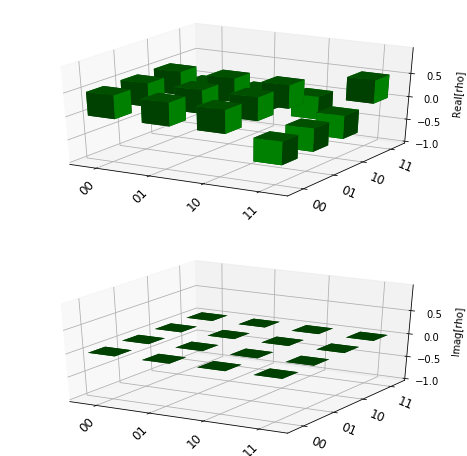

In [4]:
U_had = np.array([[1,1],[1,-1]])/np.sqrt(2)
# compute Choi-matrix from unitary
had_choi = outer(vectorize(U_had))
plot_state(had_choi)

### Simulation of process tomography experiment

Next, we build the process tomography circuits and execute them on the simulator backend

In [5]:
# process tomography set for a quantum operation on qubit 1
had_tomo_set =  tomo.process_tomography_set([1])

# Generate process tomography preparation and measurement circuits
had_tomo_circuits = tomo.create_tomography_circuits(had, qr, cr, had_tomo_set)
print('Tomography circuit names for "had" circuit:')
for circuit in had_tomo_circuits:
    print(circuit.name)

Tomography circuit names for "had" circuit:
had_prep_S0(1)_meas_X(1)
had_prep_S0(1)_meas_Y(1)
had_prep_S0(1)_meas_Z(1)
had_prep_S1(1)_meas_X(1)
had_prep_S1(1)_meas_Y(1)
had_prep_S1(1)_meas_Z(1)
had_prep_S2(1)_meas_X(1)
had_prep_S2(1)_meas_Y(1)
had_prep_S2(1)_meas_Z(1)
had_prep_S3(1)_meas_X(1)
had_prep_S3(1)_meas_Y(1)
had_prep_S3(1)_meas_Z(1)


In [6]:
backend = Aer.get_backend('qasm_simulator')
shots = 1000
had_tomo_job = execute(had_tomo_circuits, shots=shots, backend=backend)
had_tomo_results = had_tomo_job.result()

Next we fit the tomographic data

Process Fidelity =  0.9968024591391678


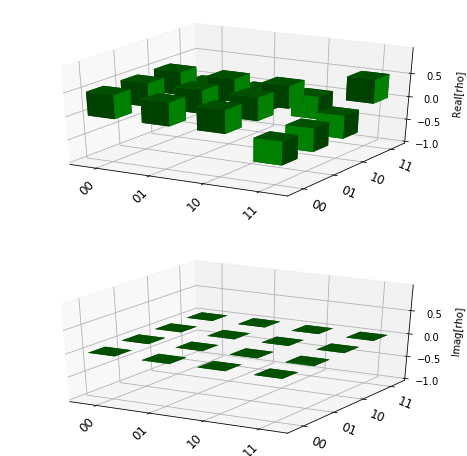

In [7]:
had_process_data = tomo.tomography_data(had_tomo_results, 'had', had_tomo_set)
had_choi_fit = tomo.fit_tomography_data(had_process_data, options={'trace':2})
print('Process Fidelity = ', state_fidelity(vectorize(U_had)/2, had_choi_fit))
plot_state(had_choi_fit)

### Running process tomography on a real device

Now we run tomography on the IBM Quantum Experience device.

In [11]:
%%qiskit_job_status
# Register API token for online backends
IBMQ.enable_account(qx_config['APItoken'], qx_config['url'])

# Use the IBM Quantum Experience
backend = least_busy(IBMQ.backends(simulator=False))

# Take 500 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 500

# set max credits
max_credits = 8

# Run the experiment
had_tomo_job_device = execute(had_tomo_circuits, backend=backend, shots=shots, max_credits=max_credits)

A Jupyter Widget

You can monitor the status of you job, and ask for the result.

Note: a call to job.result() blocks until the job execution is done and result is available.

In [9]:
# get result when it is done
had_tomo_results = had_tomo_job_device.result()

As before, we can extract the tomography data and reconstruct the choi matrix.

Process Fidelity =  0.8426471081654496


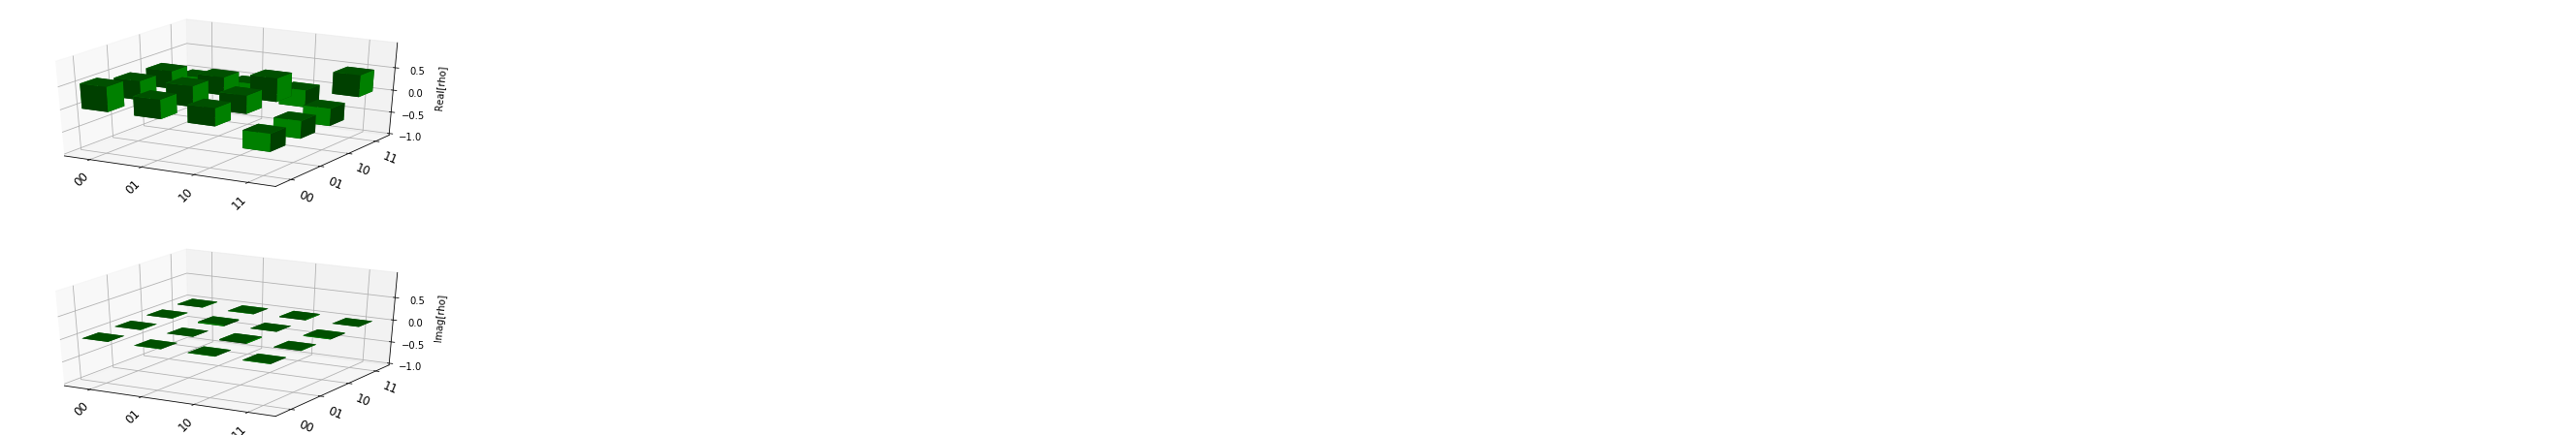

In [10]:
had_process_data = tomo.tomography_data(had_tomo_results, had.name, had_tomo_set)
had_choi_fit = tomo.fit_tomography_data(had_process_data, options={'trace':2})
print('Process Fidelity = ', state_fidelity(vectorize(U_had)/2, had_choi_fit))
plot_state(had_choi_fit)

## Process tomography of a CNOT gate

We will demonstrate a process tomography experiment for a CNOT gate.

### Visualization of the ideal process

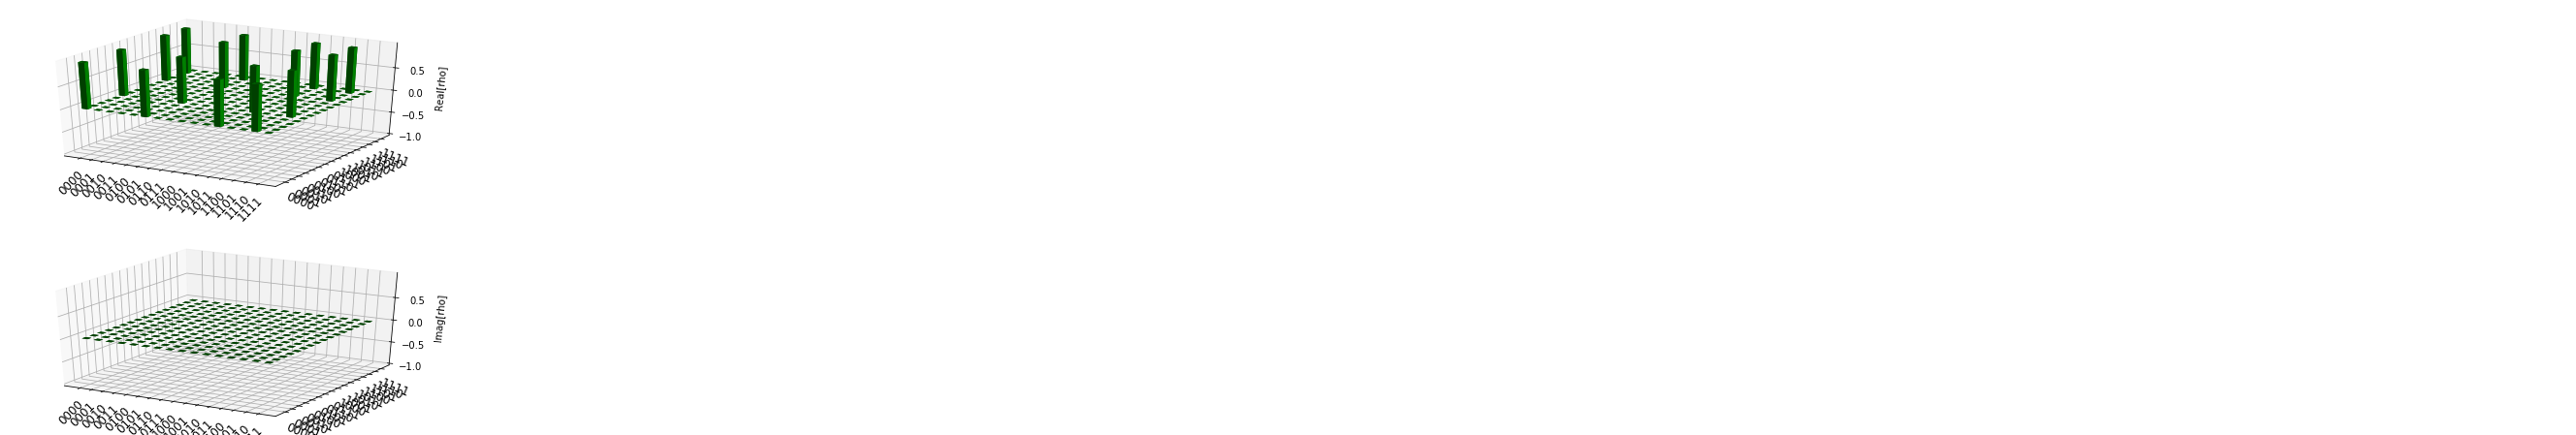

In [11]:
#unitary matrix for CNOT with qubit 1 as control and qubit 0 as target.
U_cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
# compute Choi-matrix from unitary
cnot_choi = outer(vectorize(U_cnot))
plot_state(cnot_choi)

### Simulation of process tomography experiment

Our test circuit simply consists of a quantum program of two qubits with a single gate, the CNOT gate. Note that we must include a two-qubit register to record measurement outcomes.


In [12]:
# process tomography set for quantum operation on qubits 0 and 1
cnot_tomo_set = tomo.process_tomography_set([1, 0])

# Generate process tomography circuits
cnot_tomo_circuits = tomo.create_tomography_circuits(cnot, qr, cr, cnot_tomo_set)

In [13]:
backend = Aer.get_backend('qasm_simulator')
shots = 1000
cnot_tomo_job = execute(cnot_tomo_circuits, backend=backend, shots=shots)
cnot_tomo_results = cnot_tomo_job.result()
cnot_process_data = tomo.tomography_data(cnot_tomo_results, cnot.name, cnot_tomo_set)

Now we fit the data and plot the results

Process Fidelity =  0.9904312713476582


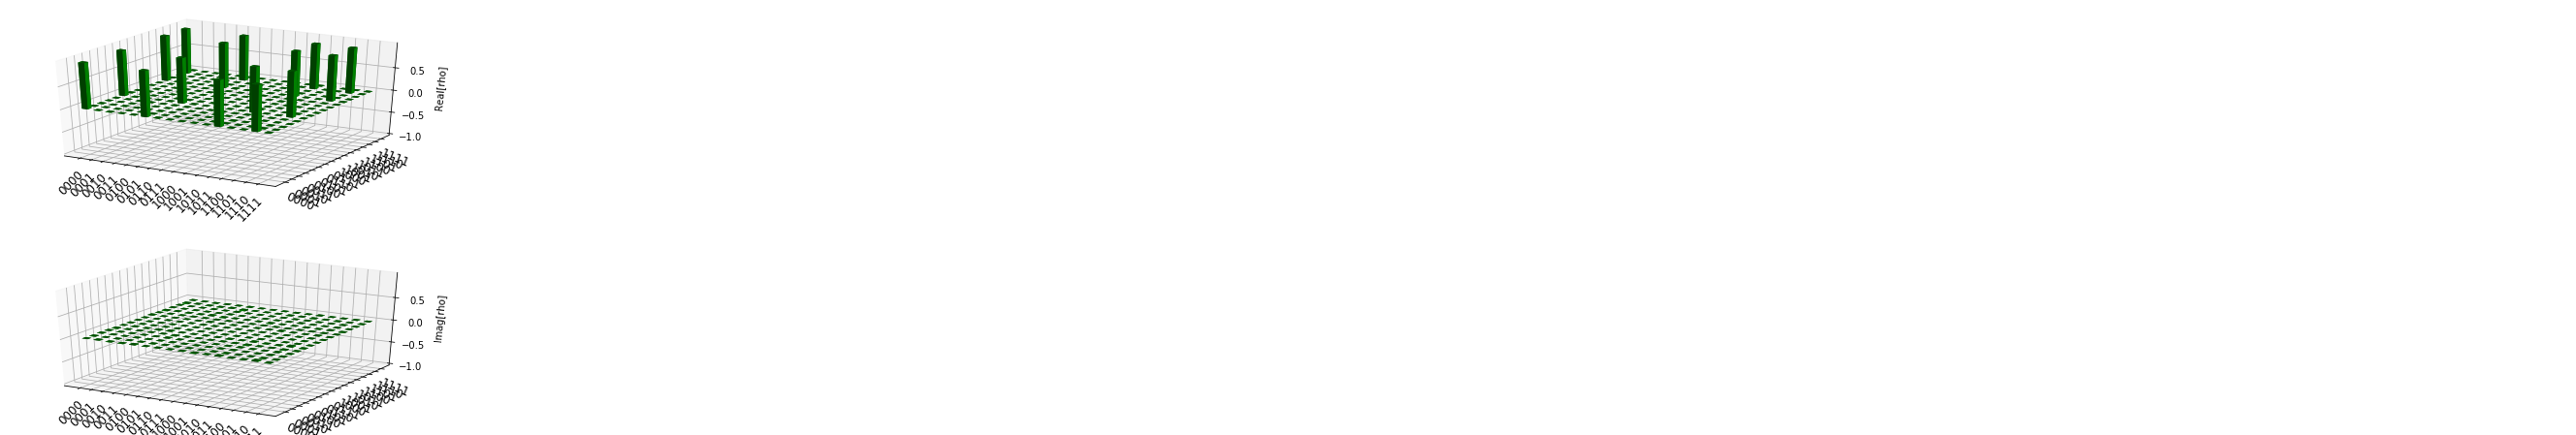

In [14]:
cnot_choi_fit = tomo.fit_tomography_data(cnot_process_data, options={'trace':4})
print('Process Fidelity = ', state_fidelity(vectorize(U_cnot)/2, cnot_choi_fit/4))
plot_state(cnot_choi_fit)

### Running process tomography on a real device

We now demonstate running tomography on a real device. Note that 2-qubit process tomography requires evaluation of 144 circuits, so circuits may need to be submitted to the device in batches, and will require many credits for evaluation on the IBM Q Experience.

We will break our submission up into 4 batches of 36 circuits for submission

In [ ]:
%%qiskit_job_status
# Use the IBM Quantum Experience
backend = least_busy(IBMQ.backends(simulator=False))

# Take 500 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 500

# set max credits
max_credits = 8

# Break circuits into batches, and submit all batches for execution
batch_size = 36
num_batches = 4
cnot_tomo_jobs = []
for j in range(num_batches):
    batch_circs = cnot_tomo_circuits[j*batch_size:(j+1)*batch_size]
    cnot_tomo_jobs.append(execute(batch_circs, backend=backend, shots=shots, max_credits=max_credits))

Get all results when completed

In [16]:
cnot_tomo_results = cnot_tomo_jobs[0].result()
for j in range(1,4):
    cnot_tomo_results += cnot_tomo_jobs[j].result()

Finally, we process and fit the process tomography data

Process Fidelity =  0.725593221367119


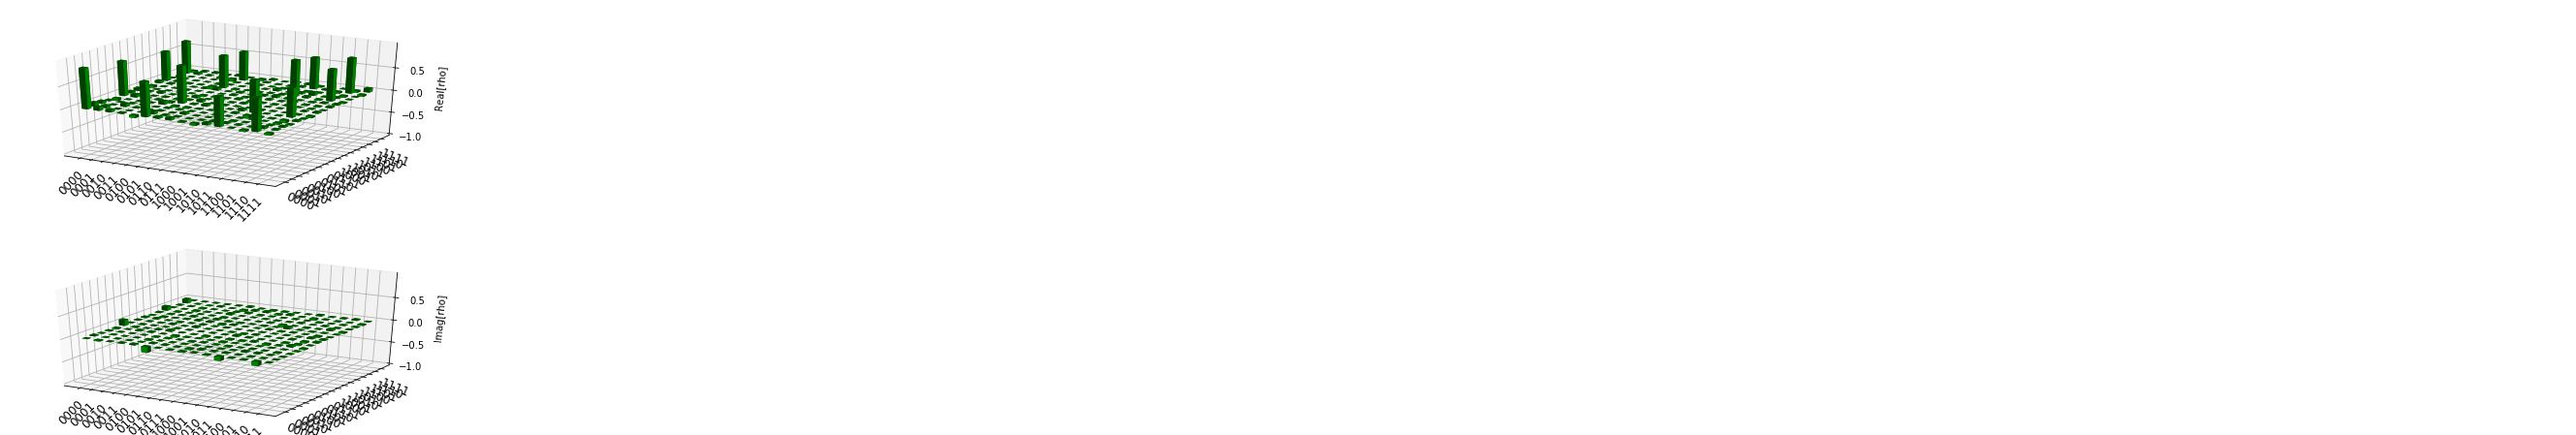

In [18]:
cnot_process_data = tomo.tomography_data(cnot_tomo_results, 'cnot', cnot_tomo_set)
cnot_choi_fit = tomo.fit_tomography_data(cnot_process_data, options={'trace':4})
print('Process Fidelity = ', state_fidelity(vectorize(U_cnot)/2, cnot_choi_fit/4))
plot_state(cnot_choi_fit)